In [27]:
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np
from google.cloud import bigquery
%load_ext google.cloud.bigquery

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.5)
#sns.set_style('darkgrid', {"xtick.minor.size": 10, "ytick.major.size": 10})
current_palette = sns.color_palette('deep')
#sns.palplot(current_palette)

# 1. Choosing Offices

For the sake of our further analysis, we need to choose certain offices to be able to do the "exact-twins" analysis for them.

Here we only keep the following offices: `EP, JP, CN, KR, DE, CA, AU, TW`

In [2]:
client = bigquery.Client()

# Creating Job Config
job_config = bigquery.QueryJobConfig()
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '01_choosing_offices'
table_ref = client.dataset(dataset_id).table(table_id)

job_config.destination = table_ref

query = """
    SELECT *
    FROM `usptobias.patstat.tls201`
    WHERE
        appln_auth IN('US', 'EP', 'JP', 'CN', 'KR', 'DE', 'CA', 'AU', 'TW')
     """
# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

# 2. Adding granted information

One additional feature that we need to add, is `legal status` of the patent applications.

For this reason we took a look at two different methods for adding this information:

### 2.1. Using `tls_231` and `tls_803` for adding legal status

In [29]:
client = bigquery.Client()

# Creating Job Config
job_config = bigquery.QueryJobConfig()
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '02_added_granted'
table_ref = client.dataset(dataset_id).table(table_id)

job_config.destination = table_ref

query = """
    SELECT
            t3.*,
            t4.appln_filing_year,
            t4.appln_auth,
            t4.granted
    FROM
            `usptobias.patstat.tls201` AS t4
    INNER JOIN (
            SELECT 
                    t1.event_id,
                    t1.appln_id,
                    t1.event_auth,
                    t1.event_code,
                    EXTRACT(YEAR FROM t1.event_filing_date) AS event_filing_year,
                    EXTRACT(YEAR FROM t1.event_publn_date) AS event_publn_year,
                    EXTRACT(YEAR FROM t1.event_effective_date) AS event_effective_date,
                    t2.event_category_code,
                    t2.event_category_title
            FROM
                    `usptobias.patstat.tls231` AS t1
            INNER JOIN (
                    SELECT 
                            event_auth,
                            event_code,
                            event_category_code,
                            Event_category_title
                    FROM
                            `usptobias.patstat.tls803`
  
            ) AS t2 ON t1.event_code=t2.event_code
    ) AS t3 ON t4.appln_id = t3.appln_id
    
     """
#### Under last INNER JOIN
#                    WHERE
#                            event_category_code IN('A','F','K','H','B')  


# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

#### Using "event_publn_date" and "event_category_code" in `tls231` and `tls803` table

In [30]:
client = bigquery.Client()

# Creating Job Config
job_config = bigquery.QueryJobConfig()
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '02_legal_counts'
table_ref = client.dataset(dataset_id).table(table_id)

job_config.destination = table_ref

query = """
    SELECT
            event_auth,
            event_publn_year,
            COUNT( DISTINCT (CASE WHEN event_category_code='A' THEN appln_id END)) AS nb_appln,
            SUM(CASE WHEN event_category_code='F' THEN 1 ELSE 0 END) AS nb_granted,
            SUM(CASE WHEN event_category_code='K' THEN 1 ELSE 0 END) AS nb_revival,
            SUM(CASE WHEN event_category_code='H' THEN 1 ELSE 0 END) AS nb_cessation,
            SUM(CASE WHEN event_category_code='B' THEN 1 ELSE 0 END) AS nb_discnt,
            SUM(CASE WHEN event_category_code='V' THEN 1 ELSE 0 END) AS nb_appeal,
            SUM(CASE WHEN event_category_code='U' THEN 1 ELSE 0 END) AS nb_payment,
            SUM(CASE WHEN event_category_code='C' THEN 1 ELSE 0 END) AS nb_appln_revival,
            SUM(CASE WHEN event_category_code='Q' THEN 1 ELSE 0 END) AS nb_publn,
            SUM(CASE WHEN event_category_code='M' THEN 1 ELSE 0 END) AS nb_maintenance,
            SUM(CASE WHEN event_category_code='Z' THEN 1 ELSE 0 END) AS nb_categorization,
            SUM(CASE WHEN event_category_code='D' THEN 1 ELSE 0 END) AS nb_search_exam,
            SUM(CASE WHEN event_category_code='T' THEN 1 ELSE 0 END) AS nb_admin_adjust,
            SUM(CASE WHEN event_category_code='Y' THEN 1 ELSE 0 END) AS nb_correction_deletion,
            SUM(CASE WHEN event_category_code='S' THEN 1 ELSE 0 END) AS nb_licensing,
            SUM(CASE WHEN event_category_code='W' THEN 1 ELSE 0 END) AS nb_other,
            COUNT(DISTINCT appln_id) as nb_appln_dist
    FROM 
        `usptobias.adding_data.02_added_granted`
    GROUP BY
        event_publn_year,
        event_auth

        
     """
# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [31]:
client = bigquery.Client()

dataset_id = 'adding_data'
table_id = '02_legal_counts'

table_ref = client.dataset(dataset_id).table(table_id)
# Getting table object
table = client.get_table(table_ref)
# Getting RowIterator object with only 10,000 first rows
rows = client.list_rows(table, max_results=10000)
# Getting the Pandas Dataframe
df_ = rows.to_dataframe()

In [32]:
print(df_.shape)
df_.sort_values(by=['event_auth', 'event_publn_year'], ascending=False).head(8)

(1510, 19)


,event_auth,event_publn_year,nb_appln,nb_granted,nb_revival,nb_cessation,nb_discnt,nb_appeal,nb_payment,nb_appln_revival,nb_publn,nb_maintenance,nb_categorization,nb_search_exam,nb_admin_adjust,nb_correction_deletion,nb_licensing,nb_other,nb_appln_dist
860,WO,2018,65926,0,0,0,293,0,0,0,0,0,0,4929,0,51,0,11109,75260
863,WO,2017,188527,0,0,0,466,0,0,0,0,0,0,9431,0,21,0,188253,359813
840,WO,2016,217194,0,0,0,244,0,0,0,0,0,0,10506,0,0,0,229334,408300
854,WO,2015,187595,0,0,0,472,0,0,0,0,0,0,13373,0,0,0,214166,375826
848,WO,2014,168014,0,0,0,189,0,0,0,0,0,0,11922,0,0,0,218543,361645
865,WO,2013,162216,0,0,0,443,0,0,0,0,0,0,12093,0,0,0,196766,339177
842,WO,2012,171158,0,0,0,213,0,0,0,0,0,0,12852,0,0,0,180086,329058
866,WO,2011,167279,7,0,4,254,0,0,0,37,0,0,13747,0,0,0,170655,310793


In [64]:
print('In total, there are {:,} distinct legal events with "Application" type and \n{:,} Application ids!'.format(df_.nb_appln.sum(),df_.nb_appln_dist.sum()))

In total, there are 9,272,745 distinct legal events with "Application" type and 
143,526,499 Application ids!


`This works the best!`

In [33]:
print(df_.shape)
df_2 = df_.sort_values(by=['event_auth', 'event_publn_year'], ascending=True).loc[:,['event_auth', 'event_publn_year', 'nb_appln', 'nb_publn', 'nb_appln_dist']]

df_2[df_2.event_auth=='US']

(1510, 19)


,event_auth,event_publn_year,nb_appln,nb_publn,nb_appln_dist
1452,US,1979,0,0,9
1451,US,1980,0,0,3120
1450,US,1981,0,0,63811
1449,US,1982,0,0,74535
795,US,1983,623,5451,80726
796,US,1984,666,5680,84579
821,US,1985,69,8473,94456
808,US,1986,0,7290,128817
803,US,1987,0,7139,169345
817,US,1988,0,8654,192168


In [73]:
df_sum = df_.iloc[:,1:].sum(axis=0)

print('There are {:,} number of all legal events in total, but there are {:,} distinct number of application ids!'
      .format(df_sum.iloc[:-1].sum(), df_sum.iloc[-1]))

There are 306,738,742 number of all legal events in total, but there are 51,700,995 distinct number of application ids!


In [82]:
df_2.sum(axis=0)

nb_appln      90520098
nb_granted    49202039
dtype: int64

### 2.1. Using "appln_filing_year" and "granted" features in `tls201`

In [34]:
%%bigquery df_2
SELECT 
    appln_auth,
    appln_filing_year,
    COUNT(DISTINCT appln_id) AS nb_appln,
    COUNT(DISTINCT(CASE WHEN granted=true THEN appln_id END)) AS nb_granted
FROM
    `usptobias.patstat.tls201`
WHERE
    appln_filing_year<9999
GROUP BY
    appln_auth,
    appln_filing_year

,appln_auth,appln_filing_year,nb_appln,nb_granted
0,CU,1946,8,0
1,PH,1986,1257,1253
2,AP,2008,410,201
3,BY,2003,53,2
4,NZ,2000,5044,0
5,CL,1941,1,0
6,US,2014,530055,264189
7,IL,2005,4060,2108
8,PH,1970,143,132
9,RS,2004,129,108


In [35]:
df_2.head()

,appln_auth,appln_filing_year,nb_appln,nb_granted
0,CU,1946,8,0
1,PH,1986,1257,1253
2,AP,2008,410,201
3,BY,2003,53,2
4,NZ,2000,5044,0


## 2.3. Doing the visualization

In [38]:
# Creating a list of authorities to keep
auth_list= ['EP', 'JP', 'CN', 'KR',
            'DE', 'CA', 'AU', 'TW']
# Filtering based on authorities
df_2_s = df_2[(df_2.appln_auth.isin(auth_list))&(df_2.appln_filing_year<=2012)&(df_2.appln_filing_year>2001)].copy()
df_s = df_[df_.event_auth.isin(auth_list)&(df_.event_publn_year<=2012)&(df_.event_publn_year>2001)].copy()

# computing the proportions
df_2_s['ratio'] = df_2_s['nb_granted']/df_2_s['nb_appln']
df_s['ratio'] = df_s['nb_granted']/df_s['nb_appln_dist']

# Changing dtype to numbers
#df_2

In [105]:
df_s.head()

,event_auth,event_publn_year,nb_appln,nb_granted,nb_revival,nb_cessation,nb_discnt,nb_appeal,nb_payment,nb_appln_revival,nb_publn,nb_maintenance,nb_categorization,nb_search_exam,nb_admin_adjust,nb_correction_deletion,nb_licensing,nb_other,nb_appln_dist,ratio
59,AU,2006,17555,8125,0,926,7131,350,0,0,205,0,39,0,564,606,22,1559,37578,0.216217
60,AU,2018,12437,12540,0,10679,5343,1891,0,0,115,0,50,136,557,249,90,249,44277,0.283217
61,AU,2009,17750,14363,0,4348,9855,720,0,0,252,0,3,193,748,3218,157,3216,52070,0.275840
62,AU,2007,19979,11487,0,1542,5815,392,0,0,259,0,29,0,785,712,38,2304,42968,0.267338
63,AU,2005,6566,5187,0,340,63428,148,0,0,115,0,61,0,429,1987,15,2386,78716,0.065895


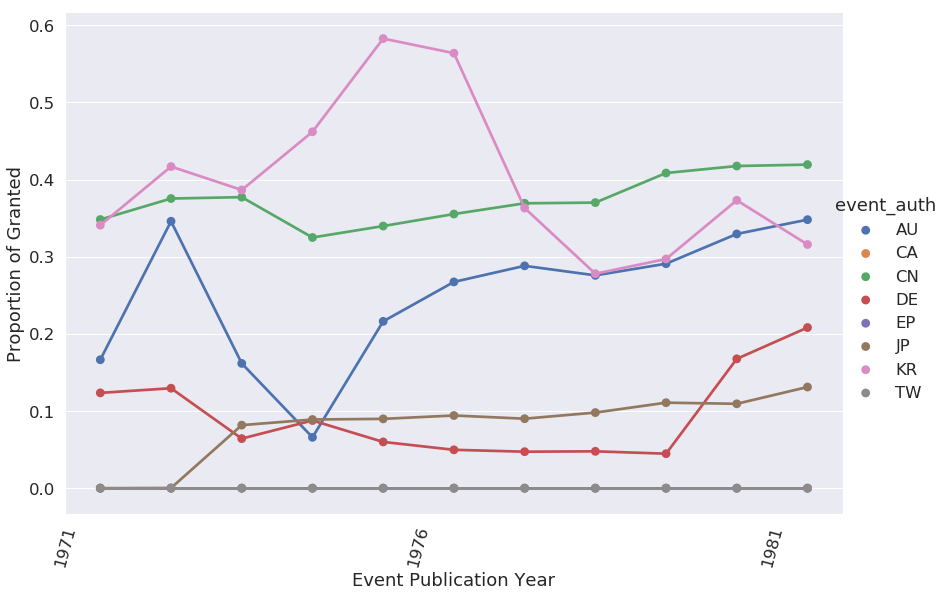

In [39]:


g = sns.catplot(x="event_publn_year", y="ratio", hue="event_auth",
                data=df_s.sort_values(by=['event_auth']), kind="point", height=8, aspect=1.5)

g.set_ylabels('Proportion of Granted', fontsize=18)
g.set_xlabels('Event Publication Year', fontsize=18)
#g.set(xscale="log")

start, end = g.ax.get_xlim()
g.ax.xaxis.set_tick_params(rotation=75)
g.ax.xaxis.set_ticks(np.arange(start, end, 5))
g.ax.xaxis.set_ticklabels(np.arange(1971, 2018, 5))

plt.setp(g._legend.get_title(),fontsize=18)
plt.show()

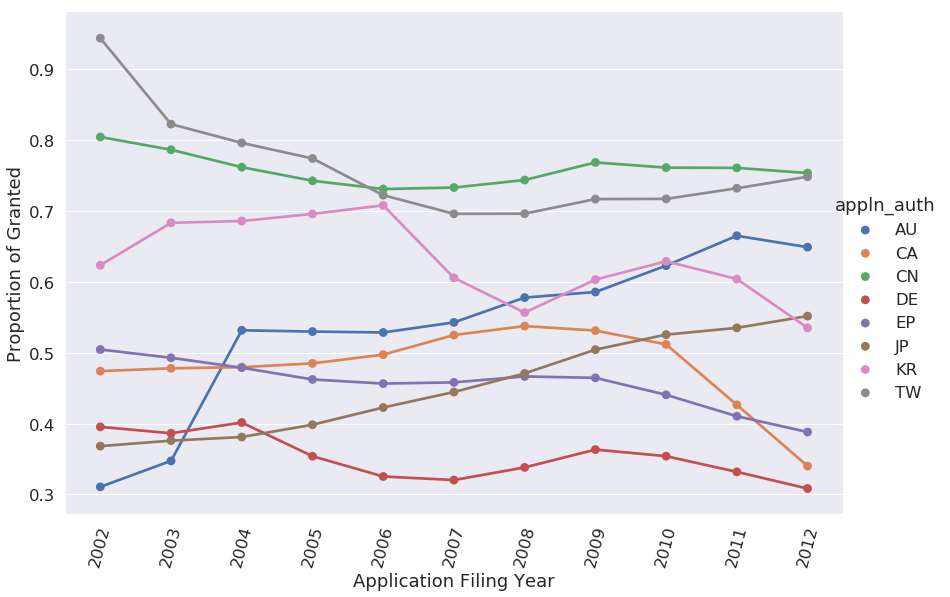

In [41]:
import matplotlib.ticker as ticker

g = sns.catplot(x="appln_filing_year", y="ratio", hue="appln_auth",
                data=df_2_s[df_2_s.appln_filing_year>1970].sort_values(by=['appln_auth']), 
                kind="point", height=8, aspect=1.5)

g.set_ylabels('Proportion of Granted', fontsize=18)
g.set_xlabels('Application Filing Year', fontsize=18)
#g.set(xscale="log")

start, end = g.ax.get_xlim()
g.ax.xaxis.set_tick_params(rotation=75)
#g.ax.xaxis.set_ticks(np.arange(start, end, 5))
#g.ax.xaxis.set_ticklabels(np.arange(2001, 2012, 5))

plt.setp(g._legend.get_title(),fontsize=18)
plt.show()

**From the visualizations in the above, we decided to use the second method (using tls201 table). Also, we are interested in the years where we have full data (after 2001) and the processing time is finished (before 2011). This way we can make sure that the legal status that we are left are either `refused` or `granted`, since there were at least 8 years for processing the application (we will investigate this statistically in the future**

### 2.4. Visualizing the status of "Search & Examined" for non-granted and granted patents

The idea here is that by looking at the proportion of non-granted patents (from tls201) that has been "Searched and Examined", we can visually see how many of those has been started to examined (thus if they are not granted yet, it means they are refused)

In [5]:
client = bigquery.Client()

# Creating Job Config
job_config = bigquery.QueryJobConfig()
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '02_searchExamined'
table_ref = client.dataset(dataset_id).table(table_id)

job_config.destination = table_ref

query = """
    SELECT
            appln_id,
            appln_auth,
            appln_filing_year,
            granted,
            (CASE WHEN event_category_code='D' THEN 1 ELSE 0 END) AS is_examined
    FROM
            `usptobias.adding_data.02_added_granted`
     """
#### Under last INNER JOIN
#                    WHERE
#                            event_category_code IN('A','F','K','H','B')  


# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

### Visualizing the "Search & Examined" proportion for non-granted patents

In [ ]:
%%bigquery df_examined
SELECT 
    appln_auth,
    appln_filing_year,
    granted,
    SUM(is_examined)*1.0/COUNT(is_examined) AS examined_ratio
FROM
    `usptobias.adding_data.02_searchExamined`
GROUP BY
    appln_auth,
    appln_filing_year,
    granted

In [17]:
auth_list = ['US', 'EP', 'JP', 'CN', 'KR', 'DE', 'CA', 'AU', 'TW']

df_examined = df_examined[df_examined.appln_auth.isin(auth_list)]
df_examined = df_examined[(df_examined.appln_filing_year>1998)&(df_examined.appln_filing_year<9999)]\
                    .sort_values(by=['granted', 'appln_auth', 'appln_filing_year'], ascending=True)
                         
df_examined.head()

,appln_auth,appln_filing_year,granted,examined_ratio
2908,AU,1999,False,0.0
1149,AU,2000,False,0.0
1290,AU,2001,False,0.0
130,AU,2002,False,0.0
1656,AU,2003,False,0.0


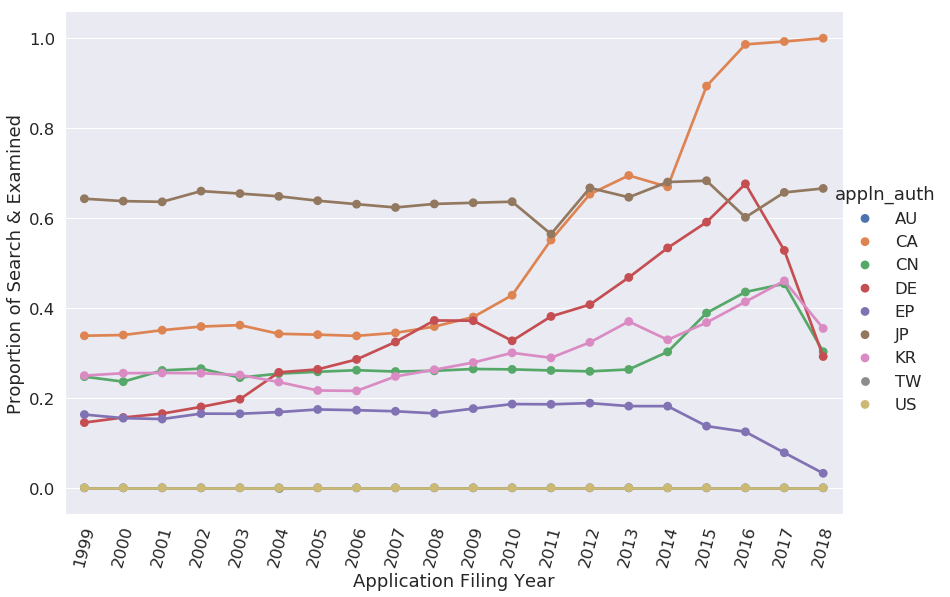

In [18]:
g = sns.catplot(x="appln_filing_year", y="examined_ratio", hue="appln_auth",
                data=df_examined[df_examined.granted==False], kind="point", height=8, aspect=1.5)

g.set_ylabels('Proportion of Search & Examined', fontsize=18)
g.set_xlabels('Application Filing Year', fontsize=18)
#g.set(xscale="log")

start, end = g.ax.get_xlim()
g.ax.xaxis.set_tick_params(rotation=75)
#g.ax.xaxis.set_ticks(np.arange(start, end, 5))
#g.ax.xaxis.set_ticklabels(np.arange(1971, 2018, 5))

plt.setp(g._legend.get_title(),fontsize=18)
plt.show()

In [28]:
%%bigquery 
SELECT 
    event_auth,
    (COUNT(CASE WHEN event_category_code=' ' THEN 1 END)*100.0/COUNT(event_category_code)) AS na_ratio,
    COUNT(event_category_code) AS count
FROM
    `usptobias.patstat.tls803`
WHERE
    event_auth IN('US', 'EP', 'JP', 'CN', 'KR', 'DE', 'CA', 'AU', 'TW')
GROUP BY
    event_auth
ORDER BY
    na_ratio DESC

,event_auth,na_ratio,count
0,DE,24.024024,333
1,EP,16.666667,246
2,US,11.111111,63
3,CN,8.602151,93
4,AU,0.000000,88
5,JP,0.000000,117
6,KR,0.000000,119
7,CA,0.000000,14
8,TW,0.000000,10


In [44]:
%%bigquery 
SELECT 
    appln_auth,
    (SUM(is_searched)*100.0/COUNT(is_searched)) AS examined_ratio,
    COUNT(DISTINCT appln_id) AS nb_appln,
    COUNT(CASE WHEN appln_auth<>event_auth THEN 1 END) AS nb_invalid_auth
FROM (
    SELECT
        appln_id,
        ANY_VALUE(appln_auth) AS appln_auth,
        ANY_VALUE(event_auth) AS event_auth,
        MAX(CASE WHEN event_category_code='D' THEN 1 ELSE 0 END) AS is_examined
    FROM
        `usptobias.adding_data.02_added_granted`
    WHERE granted=True
    GROUP BY
        appln_id
    
)
WHERE
    appln_auth IN('US', 'EP', 'JP', 'CN', 'KR', 'DE', 'CA', 'AU', 'TW')
GROUP BY
    appln_auth
ORDER BY
    appln_auth DESC

Executing query with job ID: 769d23ee-0123-4739-b4e6-2e391e3234ae
Query executing: 0.52s

BadRequest: 400 Unrecognized name: is_searched at [3:10]

In [37]:
%%bigquery 
SELECT 
    appln_auth,
    (SUM((CASE WHEN granted=True THEN 1 ElSE 0 END))*100.0/COUNT(DISTINCT appln_id)) AS granted_ratio,
    COUNT(DISTINCT appln_id) AS nb_appln
FROM
    `usptobias.patstat.tls201`
WHERE
    appln_auth IN('US', 'EP', 'JP', 'CN', 'KR', 'DE', 'CA', 'AU', 'TW')
GROUP BY
    appln_auth
ORDER BY
    granted_ratio DESC

,appln_auth,granted_ratio,nb_appln
0,TW,76.184651,1315261
1,US,67.678847,15418302
2,CN,65.848282,16086649
3,KR,58.968980,3910690
4,CA,54.140809,3361843
5,EP,47.263250,3477190
6,AU,40.265665,1483671
7,DE,39.947449,7463230
8,JP,33.996856,19941653


In [40]:
%%bigquery 
SELECT 
    *    
FROM
    `usptobias.patstat.tls803`
WHERE
    event_auth='US'
    AND event_category_code<>' '

,event_auth,event_code,event_impact,event_descr,event_descr_orig,event_category_code,event_category_title
0,US,712F,,GB: DETERMINATION OF FOREIGN ENTITLEMENT (SECT...,GB: DETERMINATION OF FOREIGN ENTITLEMENT (SECT...,W,OTHER
1,US,712J,,GB: DETERMINATION OF FOREIGN ENTITLEMENT (SECT...,GB: DETERMINATION OF FOREIGN ENTITLEMENT (SECT...,W,OTHER
2,US,XX,,MISCELLANEOUS:,MISCELLANEOUS:,W,OTHER
3,US,FEPP,,FEE PAYMENT PROCEDURE,FEE PAYMENT PROCEDURE,U,PAYMENT
4,US,REFU,,REFUND,REFUND,U,PAYMENT
5,US,REMI,,MAINTENANCE FEE REMINDER MAILED,MAINTENANCE FEE REMINDER MAILED,U,PAYMENT
6,US,AS,,ASSIGNMENT,ASSIGNMENT,R,PARTY DATA CHANGE
7,US,XAS,,NOT ANY MORE IN US ASSIGNMENT DATABASE,NOT ANY MORE IN US ASSIGNMENT DATABASE,R,PARTY DATA CHANGE
8,US,ENP,,ENTRY INTO THE NATIONAL PHASE IN:,ENTRY INTO THE NATIONAL PHASE IN:,A,APPLICATION FILING
9,US,CC,,CERTIFICATE OF CORRECTION,CERTIFICATE OF CORRECTION,Q,DOCUMENT PUBLICATION


In [5]:
%%bigquery
SELECT 
    event_category_code,
    ANY_VALUE(event_category_title)
FROM
    `usptobias.patstat.tls803`
GROUP BY
    event_category_code

,event_category_code,f0_
0,,
1,W,OTHER
2,V,APPEAL
3,U,PAYMENT
4,F,IP RIGHT GRANT
5,K,IP RIGHT REVIVAL
6,R,PARTY DATA CHANGE
7,A,APPLICATION FILING
8,H,IP RIGHT CESSATION
9,C,APPLICATION REVIVAL


## 4. Adding "inventors" and "applicants" from `tls207` and `tls206` tables

In [156]:
client = bigquery.Client()

# Creating Job Config
job_config = bigquery.QueryJobConfig()
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '04_added_person_info'
table_ref = client.dataset(dataset_id).table(table_id)

job_config.destination = table_ref

query = """
    SELECT
        t1.*,
        t2.person_id,
        t2.is_applt,
        t2.is_invt
    FROM 
        `usptobias.patstat.tls201` AS t1
    INNER JOIN (
        SELECT
            person_id,
            appln_id,
            (CASE WHEN applt_seq_nr>0 THEN 1 ELSE 0 END) AS is_applt,
            (CASE WHEN invt_seq_nr>0 THEN 1 ELSE 0 END) AS is_invt
        FROM
            `usptobias.patstat.tls207`
    ) AS t2 USING(appln_id)

     """
# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [158]:
client = bigquery.Client()

dataset_id = 'adding_data'
table_id = '04_added_person_info'

table_ref = client.dataset(dataset_id).table(table_id)
# Getting table object
table = client.get_table(table_ref)

print("\nThere are {:,} number of records in total!"
      .format(table.num_rows))

# Getting RowIterator object with only 10,000 first rows
rows = client.list_rows(table, max_results=10000)
# Getting the Pandas Dataframe
df_ = rows.to_dataframe()
df_.head()


There are 234,935,983 number of records in total!


,appln_id,appln_auth,appln_nr,appln_kind,appln_filing_date,appln_filing_year,appln_nr_epodoc,appln_nr_original,ipr_type,receiving_office,...,granted,docdb_family_id,inpadoc_family_id,docdb_family_size,nb_citing_docdb_fam,nb_applicants,nb_inventors,person_id,is_applt,is_invt
0,473727144,CN,201620834451,U,2016-08-01,2016,CN20162834451U,201620834451,UM,,...,True,57702198,24044882,1,0,1,2,41574779,0,1
1,20559432,FR,9712336,A,1997-10-03,1997,FR19970012336,9712336,PI,,...,True,9511782,971968,21,9,1,5,5721642,1,0
2,20694192,FR,1066949D,A,1952-11-14,1952,FRD1066949,,PI,,...,True,7719217,11815081,1,0,1,0,12682820,1,0
3,332578962,CN,201010540231,A,2010-11-11,2010,CN20101540231,2010105402313,PI,,...,False,43640865,15909109,1,1,2,11,41791361,0,1
4,332589325,YU,P20050379,A,2005-05-19,2005,YU2005P000379,P-2005/0379,PI,,...,False,43646378,57591901,1,0,1,1,42335019,1,1


## 5. Adding number of Claims

    The number of publication claims are available only for "US" 
    (Not US-publications published on or before 1974) and 
    "EP" (A3, A8, B8 and non-republished EuroPCT applications) applications.
    
    - The default value is Zero!

In [6]:
client = bigquery.Client()

# Creating Job Config
job_config = bigquery.QueryJobConfig()
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '05_added_claims_info'
table_ref = client.dataset(dataset_id).table(table_id)

job_config.destination = table_ref

query = """
    SELECT
        t1.appln_id,
        ANY_VALUE(t1.appln_auth),
        ANY_VALUE(t1.appln_kind),
        ANY_VALUE(t1.appln_filing_year),
        ANY_VALUE(t1.granted),
        ANY_VALUE(t2.pat_publn_id),
        SUM(t2.publn_claims) AS nb_claims
    FROM 
        `usptobias.patstat.tls201` AS t1
    INNER JOIN (
        SELECT
            pat_publn_id,
            appln_id,
            publn_claims
        FROM
            `usptobias.patstat.tls211`
    ) AS t2 USING(appln_id)
    GROUP BY
        appln_id

     """
# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [10]:
client = bigquery.Client()

dataset_id = 'adding_data'
table_id = '05_added_claims_info'

table_ref = client.dataset(dataset_id).table(table_id)
# Getting table object
table = client.get_table(table_ref)

print("\nThere are {:,} number of records in total!"
      .format(table.num_rows))

# Getting RowIterator object with only 10,000 first rows
rows = client.list_rows(table, max_results=10000)
# Getting the Pandas Dataframe
df_ = rows.to_dataframe()
df_.head()


There are 88,717,537 number of records in total!


,appln_id,f0_,f1_,f2_,f3_,f4_,nb_claims
0,477891422,WO,W,2017,False,484973153,0
1,478119366,US,F,2015,True,478119367,1
2,478345042,US,A,2016,False,478345043,0
3,478597569,US,A,2016,False,478597570,0
4,478948825,US,A,2017,False,478948826,0


## 6. Adding Examiner and Attorney information

In [3]:
data_folder = './data/'

In [8]:
import os

In [10]:
list(os.walk(data_folder))

[('./data/',
  [],
  ['lawyer.tsv.zip',
   'patent_assignee.tsv.zip',
   'rawexaminer.tsv.zip',
   'patent_lawyer.tsv.zip'])]

    First method for loading Lawyers' data

In [11]:
df_lawyer = pd.read_csv(data_folder+'lawyer.tsv.zip', 
                        compression='zip', sep='\t', 
                        nrows=200)

df_lawyer.head()

,id,name_first,name_last,organization,country
0,00001d98f0f7955b659fc7c9195e0d88,Joan Ootican,Herman,NaN,NaN
1,00016d39cbd432ff25699d80e86f38e8,NaN,NaN,Law Office of Alan W Cannon,NaN
2,0001900c20b9ee4bcdbdd0f770cccf78,Alek P.,Saecsy,NaN,US
3,0001da0313fee14b313924087135bfcc,Michael J.,Wens,NaN,US
4,000242ab861351972f5cd16d5d75c970,NaN,NaN,"Weingarten, Schrugin, Gagnebin & Lebovici LLP",US


In [27]:
df_patent_lawyer = pd.read_csv(data_folder+'patent_lawyer.tsv.zip', 
                        compression='zip', sep='\t', 
                        nrows=200)

df_patent_lawyer.head()

,patent_id,lawyer_id
0,10117999,a19e06176e1b8cb3e5044ffb889de3ed
1,4253071,fbba8f4e97c00c6812c9ad2ce3ebb253
2,9194701,f57216e06bfffc809009044c9e4779e7
3,8380450,edd92d11f7bc7bfe2d948d18cc96fa11
4,7066774,fffa05e888783185577b711bf87c9967


    Second method for loading Lawyers' data

In [28]:
df_raw_lawyer = pd.read_csv(data_folder+'rawlawyer.tsv.zip', 
                        compression='zip', sep='\t', 
                        nrows=200)

df_raw_lawyer.head()

,uuid,lawyer_id,patent_id,name_first,name_last,organization,country,sequence
0,00000gmlfky3errv570omoywc,a19e06176e1b8cb3e5044ffb889de3ed,10117999,Wesley,Nicolas,NaN,NaN,1
1,00000hg3piqc9ah8ttcsbu1zi,fbba8f4e97c00c6812c9ad2ce3ebb253,4253071,Willim J.,Streeter,NaN,NaN,1
2,00004qpq87mbwj3e8daybx9ep,f57216e06bfffc809009044c9e4779e7,9194701,NaN,NaN,Maschoff Brennan,NaN,1
3,00008ys7tutrwtb9p86rmwmzt,edd92d11f7bc7bfe2d948d18cc96fa11,8380450,NaN,NaN,"Oliff & Berridge, PLC",NaN,1
4,0000hj1toi1cef0x7l4nio2dm,fffa05e888783185577b711bf87c9967,7066774,NaN,NaN,"Thompson Coburn, LLP",NaN,1


    Comparing the two methods

In [26]:
print('Number of NAs in table "rawlawyer.tsv.zip" :\n  1. Column "name_first: {:,}"'
      .format(df_.drop_duplicates(subset=['lawyer_id']).name_first.isna().sum()))
print('  2. Column "name_last": {:,}'
      .format(df_.drop_duplicates(subset=['lawyer_id']).name_last.isna().sum()))
print('  3. Column "Organization": {:,}'
      .format(df_.drop_duplicates(subset=['lawyer_id']).organization.isna().sum()))
print('  4. Column "Country": {:,}'
      .format(df_.drop_duplicates(subset=['lawyer_id']).country.isna().sum()))

Number of NAs in table "rawlawyer.tsv.zip" :
  1. Column "name_first: 73,176"
  2. Column "name_last": 73,176
  3. Column "Organization": 93,073
  4. Column "Country": 148,855


In [22]:
print('Number of NAs in table "lawyer.tsv.zip" :\n  1. Column "name_first: {:,}"'
      .format(df_.drop_duplicates(subset=['id']).name_first.isna().sum()))
print('  2. Column "name_last": {:,}'
      .format(df_.drop_duplicates(subset=['id']).name_last.isna().sum()))
print('  3. Column "Organization": {:,}'
      .format(df_.drop_duplicates(subset=['id']).organization.isna().sum()))
print('  4. Column "Country": {:,}'
      .format(df_.drop_duplicates(subset=['id']).country.isna().sum()))

Number of NAs in table "lawyer.tsv.zip" :
  1. Column "name_first: 73,183"
  2. Column "name_last": 73,183
  3. Column "Organization": 93,068
  4. Column "Country": 148,824


    Loading Assignees' data

In [13]:
df_assignee = pd.read_csv(data_folder+'patent_assignee.tsv.zip', 
                        compression='zip', sep='\t', 
                        nrows=200)

df_assignee.head()

,patent_id,assignee_id
0,5856666,org_gH4JQPzUdVZTUPCpOF8C
1,5204210,org_seWF1XJsYBsNMdnUfyrj
2,5302149,org_a8GQVDI0vSHucBKsNgZc
3,9104354,org_ZGKGyMmA1KkoJAuRI1CA
4,6584517,org_Hw8MCcSYDQsq0k1E8X3a


    Loading Examiners' data

In [35]:
df_raw_examiner = pd.read_csv(data_folder+'rawexaminer.tsv.zip', 
                        compression='zip', sep='\t', 
                        nrows=2000)

df_raw_examiner.head()

,uuid,patent_id,name_first,name_last,role,group
0,0000029n6b9b06k1eyuheb5lh,8352492,Son T,Hoang,primary,2169.0
1,0000a4vpqj2j7533gvm3b9l9c,5059397,Timothy M.,McMahon,assistant,NaN
2,0000g409v54neyo4bj2n06a3r,7356646,Fred W,Detschel,assistant,2187.0
3,0000gfwo773fhcloe90qdizqh,5676706,Caroline L.,Dusheck,assistant,NaN
4,0000ofhmvgma8bfxs4kto6zpw,10067073,Joshua D,Anderson,assistant,3729.0


    Loading "Application" data

In [36]:
df_application = pd.read_csv(data_folder+'application.tsv.zip', 
                        compression='zip', sep='\t', 
                        nrows=2000)

df_application.head()

,id,patent_id,series_code,number,country,date
0,02/002761,D345393,2,2002761,US,1992-12-21
1,02/007691,5164715,2,2007691,US,1990-04-10
2,02/010248,5177974,2,2010248,US,1988-06-23
3,02/020141,5379515,2,2020141,US,1994-02-16
4,02/027172,5264790,2,2027172,US,1991-07-01


    Loading "Patents" data

In [9]:
from zipfile import ZipFile

file = ZipFile(data_folder+'patent.tsv.zip', 'r')
object_file = file.read('data/20181127/bulk-downloads/patent.tsv')
lines = sum(1 for row in object_file)

In [12]:
del file, object_file

In [11]:
print('{:,}'.format(lines))

5,259,627,588


In [7]:
df_patent = pd.read_csv(data_folder+'patent.tsv', 
                        sep='\t', low_memory=False, nrows=1000000)

df_patent.head()

,id,type,number,country,date,abstract,title,kind,num_claims,filename,withdrawn
0,10000000,utility,10000000,US,2018-06-19,A frequency modulated (coherent) laser detecti...,Coherent LADAR using intra-pixel quadrature de...,B2,20,ipg180619.xml,NaN
1,10000001,utility,10000001,US,2018-06-19,The injection molding machine includes a fixed...,Injection molding machine and mold thickness c...,B2,12,ipg180619.xml,NaN
2,10000002,utility,10000002,US,2018-06-19,The present invention relates to: a method for...,Method for manufacturing polymer film and co-e...,B2,9,ipg180619.xml,NaN
3,10000003,utility,10000003,US,2018-06-19,The invention relates to a method for producin...,Method for producing a container from a thermo...,B2,18,ipg180619.xml,NaN
4,10000004,utility,10000004,US,2018-06-19,The present invention relates to provides a do...,"Process of obtaining a double-oriented film, c...",B2,6,ipg180619.xml,NaN


## Linking the Correspondence ID between "PatentsView" and "PatStat"

In [10]:
df_mapping = pd.read_csv(data_folder+'patentid_applnid.txt', 
                        sep='\t', low_memory=False)

df_mapping.head()

,patent_id,APPLN_ID
0,3930271,51621246.0
1,3930272,51379297.0
2,3930273,51677498.0
3,3930274,51475922.0
4,3930275,51858978.0


In [11]:
df_mapping.to_csv(data_folder+'mapping.csv.gz', compression='gzip', index=False, encoding='utf-8')

In [29]:
# Finding the application IDs from "PatStat" that are not in "PatentsView"
"""
SELECT
  b.APPLN_FILING_YEAR,
  Count(b.APPLN_ID) AS APPLN_COUNT
FROM
  patentsview.patentid_applnid a
  INNER JOIN patstat.tls201_appln b ON b.APPLN_ID = a.APPLN_ID
WHERE
  a.patent_id IS NULL
GROUP BY
  b.APPLN_FILING_YEAR
"""

'\nSELECT\n  b.APPLN_FILING_YEAR,\n  Count(b.APPLN_ID) AS APPLN_COUNT\nFROM\n  patentsview.patentid_applnid a\n  INNER JOIN patstat.tls201_appln b ON b.APPLN_ID = a.APPLN_ID\nWHERE\n  a.patent_id IS NULL\nGROUP BY\n  b.APPLN_FILING_YEAR\n'

## 7. Newly Downloaded data from USPTO

In [1]:
from zipfile import ZipFile

data_folder = './data/USPTO/'
zip_file = ZipFile(data_folder+'Patent_Examination_Data_System')

json_file = zip_file.read('1.json')

In [2]:
import json

json_file = json.loads(json_file)


In [11]:
print(json_file['PatentBulkData'][0]['patentRecordBag']['patentRecord'][0].keys())

dict_keys(['patentCaseMetadata', 'prosecutionHistoryDataBag', 'st96Version', 'ipoVersion'])


In [ ]:
print(json.dumps(json_file['PatentBulkData'][0]['patentRecordBag']['patentRecord'][0]['patentCaseMetadata'], indent=4, sort_keys=True))

In [6]:
import pandas as pd

df_ = pd.DataFrame.from_dict(json_file['PatentBulkData'][0]['patentRecordBag']['patentRecord'][0]['patentCaseMetadata'])

In [43]:
pd.options.display.max_colwidth = 60

In [7]:
df_.head(40)

,applicationNumberText,filingDate,applicationTypeCategory,partyBag,groupArtUnitNumber,applicationConfirmationNumber,applicantFileReference,patentClassificationBag,businessEntityStatusCategory,firstInventorToFileIndicator,inventionTitle,applicationStatusCategory,applicationStatusDate,officialFileLocationCategory,relatedDocumentData
applicantBagOrInventorBagOrOwnerBag,NaN,0001-10-06,Utility,[{'primaryExaminerOrAssistantExaminerOrAuthori...,NaN,3482,3502-1095,NaN,UNDISCOUNTED,false,NaN,Abandoned -- Failure to Respond to an Office...,2008-11-19,ELECTRONIC,NaN
content,NaN,0001-10-06,Utility,NaN,NaN,3482,3502-1095,NaN,UNDISCOUNTED,false,[Method and device for detecting a signal havi...,Abandoned -- Failure to Respond to an Office...,2008-11-19,ELECTRONIC,NaN
cpcClassificationBagOrIPCClassificationOrECLAClassificationBag,NaN,0001-10-06,Utility,NaN,NaN,3482,3502-1095,"[{'ipOfficeCode': 'US', 'mainNationalClassific...",UNDISCOUNTED,false,NaN,Abandoned -- Failure to Respond to an Office...,2008-11-19,ELECTRONIC,NaN
electronicText,09700298,0001-10-06,Utility,NaN,2831,3482,3502-1095,NaN,UNDISCOUNTED,false,NaN,Abandoned -- Failure to Respond to an Office...,2008-11-19,ELECTRONIC,NaN
parentDocumentDataOrChildDocumentData,NaN,0001-10-06,Utility,NaN,NaN,3482,3502-1095,NaN,UNDISCOUNTED,false,NaN,Abandoned -- Failure to Respond to an Office...,2008-11-19,ELECTRONIC,[{'descriptionText': 'This application is Nati...
value,09700298,0001-10-06,Utility,NaN,2831,3482,3502-1095,NaN,UNDISCOUNTED,false,NaN,Abandoned -- Failure to Respond to an Office...,2008-11-19,ELECTRONIC,NaN


In [45]:
df_.iloc[9,0]

{'value': '2831', 'electronicText': '2831'}

In [22]:
from pandas.io.json import json_normalize

json_normalize(json_file['PatentBulkData'][0]['patentRecordBag']['patentRecord'][0])

,ipoVersion,patentCaseMetadata.applicantFileReference,patentCaseMetadata.applicationConfirmationNumber,patentCaseMetadata.applicationNumberText.electronicText,patentCaseMetadata.applicationNumberText.value,patentCaseMetadata.applicationStatusCategory,patentCaseMetadata.applicationStatusDate,patentCaseMetadata.applicationTypeCategory,patentCaseMetadata.businessEntityStatusCategory,patentCaseMetadata.filingDate,patentCaseMetadata.firstInventorToFileIndicator,patentCaseMetadata.groupArtUnitNumber.electronicText,patentCaseMetadata.groupArtUnitNumber.value,patentCaseMetadata.inventionTitle.content,patentCaseMetadata.officialFileLocationCategory,patentCaseMetadata.partyBag.applicantBagOrInventorBagOrOwnerBag,patentCaseMetadata.patentClassificationBag.cpcClassificationBagOrIPCClassificationOrECLAClassificationBag,patentCaseMetadata.relatedDocumentData.parentDocumentDataOrChildDocumentData,prosecutionHistoryDataBag.prosecutionHistoryData,st96Version
0,US_V8_0_D8,3502-1095,3482,09700298,09700298,Abandoned -- Failure to Respond to an Office...,2008-11-19,Utility,UNDISCOUNTED,0001-10-06,false,2831,2831,[Method and device for detecting a signal havi...,ELECTRONIC,[{'primaryExaminerOrAssistantExaminerOrAuthori...,"[{'ipOfficeCode': 'US', 'mainNationalClassific...",[{'descriptionText': 'This application is Nati...,"[{'eventDate': '2008-11-19', 'eventDescription...",V3_0


In [20]:
len(json_file['PatentBulkData'][0]['patentRecordBag']['patentRecord'])

1

In [14]:
import os
data_folder = './data/USPTO/'

list(os.walk(data_folder))

[('./data/USPTO/',
  [],
  ['assignment_dataset.csv.zip',
   'Patent_Examination_Data_System',
   'csv.zip.1'])]

In [24]:
from zipfile import ZipFile
from io import StringIO

uspto_zip = ZipFile(data_folder+'assignment_dataset.csv.zip')

df_assignment = pd.read_csv(uspto_zip.open('assignment.csv'), nrows=200)
df_assignee = pd.read_csv(uspto_zip.open('assignee.csv'), nrows=200)
df_documentid = pd.read_csv(uspto_zip.open('documentid.csv'), nrows=200)

In [23]:
df_assignment.head()

,rf_id,file_id,cname,caddress_1,caddress_2,caddress_3,caddress_4,reel_no,frame_no,convey_text,record_dt,last_update_dt,page_count,purge_in
0,12800340,1,THOMAS J. ENGELLENNER,LAHIVE & COCKFIELD,60 STATE STREET,SUITE 510,"BOSTON, MA 02109",1280,340,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT...,1994-12-30,1999-07-29,2,N
1,36250888,1,NORTHERN TELECOM LIMITED,PATENT DEPT 265,P.O. BOX 3511 STATION C,OTTAWA ONTARIO CANADA K1Y 4H7,NaN,3625,888,CHANGE OF NAME (SEE DOCUMENT FOR DETAILS).,1979-03-05,2010-09-24,4,N
2,36340874,1,MORRISON & FOERSTER LLP,GARY E. CANN,345 CALIFORNIA STREET,"SAN FRANCISCO, CA 94104-2675",NaN,3634,874,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT...,1979-03-02,1999-08-17,1,N
3,36340875,1,THOMAS KAYDEN HORSTEMEYER ET AL.,DANIEL A. MCCLURE,"100 GALLERIA PARKWAY, STE. 1500","ATLANTA, GA 30339",NaN,3634,875,ASSIGNMENT OF ASSIGNOR'S INTEREST (SEE DOCUMEN...,1979-03-02,1999-08-17,1,N
4,36920537,1,"EHD, INC.",500 GOULD DRIVE,"COOKEVILLE, TN 38501",NaN,NaN,3692,537,ASSIGNMENT OF ASSIGNORS INTEREST (SEE DOCUMENT...,1979-09-26,2002-04-06,3,N


In [25]:
df_assignee.head()

,rf_id,ee_name,ee_address_1,ee_address_2,ee_city,ee_state,ee_postcode,ee_country
0,12800340,CHILDREN'S MEDICAL CENTER CORPORATION,"55 SHATTUCK STREET BOSTON, MA 02115",NaN,NaN,NaN,NaN,NaN
1,36250888,NORTHERN TELECOM LIMITED,NaN,NaN,NaN,NaN,NaN,NOT PROVIDED
2,36340874,PARADYNE CORPORATION,NaN,8550 ULMERTON ROAD,LARGO,FLORIDA,33540,NaN
3,36340875,PARADYNE CORPORATION,NaN,8550 ULMERTON ROAD,LARGO,FLORIDA,33540,NaN
4,36920537,"EHD, INC.",A TENNESSEE CORPORATION,500 GOULD DRIVE,COOKEVILLE,TENNESSEE,38501,NaN


In [26]:
df_documentid.head()

,rf_id,title,lang,appno_doc_num,appno_date,appno_country,pgpub_doc_num,pgpub_date,pgpub_country,grant_doc_num,grant_date,grant_country
0,12800340,SYSTEMS AND METHODS FOR PROMOTING TISSUE GROWTH,en,8326711,1994-10-20,US,NaN,NaN,NaN,5858003,1999-01-12,US
1,36250888,OPTICAL FIBRE HAVING LOW MODE DISPERSION,en,5855408,1977-11-28,US,NaN,NaN,NaN,4149772,1979-04-17,US
2,36250888,NaN,NaN,5517218,NaN,US,NaN,NaN,NaN,3936602,NaN,US
3,36250888,POLYMER COATED HEAT INSULATED ELECTRICAL CONDU...,en,5574608,1975-05-05,US,NaN,NaN,NaN,4131690,1978-12-26,US
4,36250888,NaN,NaN,5604353,NaN,US,NaN,NaN,NaN,D244456,NaN,US
